imports

In [1]:
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
import re
import fnmatch
import h5py
import csv
from matplotlib.mlab import cross_from_below
# import seaborn as sns
# sns.set(style='ticks', context='talk') #aesthetics
# plt.style.use("dark_background") #aesthetics

In [2]:
import openephys.OpenEphys as oe
from braintv_ephys_dev.workstation.danield.generalephys import option234_positions
# from braintv_ephys_dev.workstation.danield.continuous_traces import get_chunk
def get_chunk(mm,start,end,channels,sampling_rate=30000):
	duration = end - start
	samples = int(np.round(duration * sampling_rate))
	start_sample = int(start*sampling_rate)*int(channels)
	chunk = mm[start_sample:\
			   start_sample + samples * int(channels)]#int(int(np.floor(np.ceil(end*sampling_rate))*(int(channels))))]
	#print np.shape(chunk)
	return np.reshape(chunk,(int(channels),-1),order='F')  * (0.000195)

In [3]:
def load_phy_spiketimes(path):
    all_spiketimes = []
    all_cluster_numbers = []

    clusters_data = np.load(os.path.join(path,'spike_clusters.npy'))
    spikes_data = np.load(os.path.join(path,'spike_times.npy'))
    spike_templates = np.load(os.path.join(path,'spike_templates.npy'))
    templates = np.load(os.path.join(path,'templates.npy'))

    cluster_groups = []
    [cluster_groups.append(row) for row in csv.reader(open(os.path.join(path,'cluster_group.tsv')))];
    spiketime_information = {}
    for i in np.arange(1,np.shape(cluster_groups)[0]):
        if cluster_groups[i][0].split('\t')[1] == 'good':           #if it is a 'good' cluster by manual sort
            unit = int(cluster_groups[i][0].split('\t')[0])
            spiketime_information[str(unit)] = {}

            spiketime_information[str(unit)]['spike_times'] = spikes_data[np.where(clusters_data==unit)]/30000.    
            spiketime_information[str(unit)]['spike_times']= spiketime_information[str(unit)]['spike_times'].flatten()

            #get the mean template used for this unit
            all_templates = spike_templates[np.where(clusters_data==unit)].flatten()
            n_templates_to_subsample = 100
            random_subsample_of_templates = templates[all_templates[np.array(np.random.rand(n_templates_to_subsample)*all_templates.shape[0]).astype(int)]]
            mean_template = np.mean(random_subsample_of_templates,axis=0)
            spiketime_information[str(unit)]['template'] = mean_template

            #take a weighted average of the channelmap, where the weights is the absolute value of the template for that channel
            #this gets us the x and y positions of the unit on the probe.
    #         if 'channelmap' in kwargs.keys():
    #             channelmap = kwargs['channelmap']
    #             weights = np.zeros(channelmap.shape)
    #             for channel in range(channelmap.shape[0]):
    #                 weights[channel,:]=np.trapz(np.abs(mean_template.T[channel,:]))
    #             weights = weights/np.max(weights)
    #             (xpos,ypos)=np.average(channelmap,axis=0,weights=weights)
    #         else:
            (xpos,ypos)=(np.nan,np.nan)
    #         spiketime_information[str(unit)]['xpos'] = xpos + 6
    #         spiketime_information[str(unit)]['ypos'] = ypos - channelmap[-1][1]

            all_spiketimes.extend(spiketime_information[str(unit)]['spike_times'])
            all_cluster_numbers.extend(np.array(np.ones(len(spiketime_information[str(unit)]['spike_times']))*unit).tolist())
    return spiketime_information

# define paths here
these should be full paths [string]

In [4]:
slice_nwb_path = np.sort(glob.glob('/Users/danieljdenman/Desktop/cache/meanhwan/2019-06-25_14-59-04/*.nwb'))[0]
path = os.path.join(os.path.dirname(slice_nwb_path),'sort1')

## load data from pipettes and sorted neuropixels data

In [5]:
d = h5py.File(slice_nwb_path)
spiketime_information = load_phy_spiketimes(path)

## load sync data from pipettes and sorted neuropixels data

In [6]:
start_time = int(open(glob.glob(os.path.join(os.path.dirname(slice_nwb_path),'*messages*.events'))[0]).readlines()[0].split(' ')[0])/30000.


In [7]:
TTL0 = np.array([list(d['stimulus']['presentation'][k]['starting_time'])[0] for k in fnmatch.filter(list(d['stimulus']['presentation']), 'data_*_TTL0*')]             )
npix_events = oe.loadEvents(glob.glob(os.path.join(os.path.dirname(slice_nwb_path),'*channels*.events'))[0])
ch0 = npix_events['timestamps'][npix_events['channel']==0] - start_time


loading events...


### compare the events from the two systems
do these look pretty close?

(0.9, 1.3)

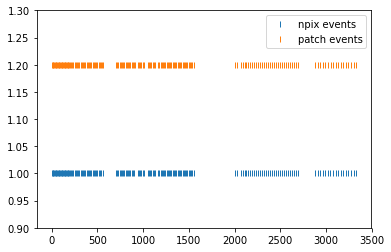

In [8]:
npix_ch0_times = ch0[8:][::2]/30000.
patch_ch0_times = TTL0[672 - int(len(ch0)/2):671]
plt.plot(npix_ch0_times-npix_ch0_times[0],np.ones(len(npix_ch0_times)),'|',label='npix events')
plt.plot(patch_ch0_times - patch_ch0_times[0],np.ones(len(patch_ch0_times))*1.2,'|',label='patch events')
plt.legend()
plt.ylim(0.9,1.3)
# plt.xlim(2000,2100)

<br></br>
### plot the np.diff's on top of each other, make sure they totally overlap. 
if not, zoom in to find out why not?

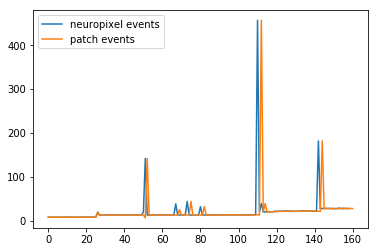

In [9]:
plt.plot(np.diff(npix_ch0_times),label='neuropixel events')
plt.plot(np.diff(patch_ch0_times),label='patch events')
plt.legend()

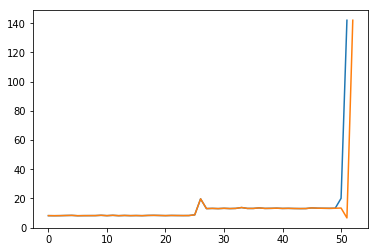

In [10]:
plt.plot(np.diff(npix_ch0_times[:53]))
plt.plot(np.diff(patch_ch0_times[:54]))

manually adjust the events so the match

In [11]:
patch_ch0_mask = np.ones(len(patch_ch0_times), dtype=bool)
patch_ch0_mask[52]=False
# patch_ch0_mask[53]=patch_ch0_mask[54]
patch_ch0_mask[53]=False
patch_ch0_redacted = patch_ch0_times[patch_ch0_mask]

replot the diffs

(58, 83)

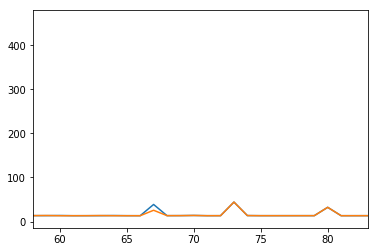

In [12]:
plt.plot(np.diff(npix_ch0_times))
# plt.plot(np.diff(patch_ch0_times[patch_ch0_mask]))
plt.plot(np.diff(patch_ch0_redacted))
plt.xlim(58,83)

In [13]:
patch_ch0_times = patch_ch0_redacted

In [14]:
offset= npix_ch0_times[0]-start_time - patch_ch0_times[0]

digest some pipette data<br></br>
[note that there is a manual offset of ~250 msec that i don't understand]

In [15]:
.252265 - .0378

0.21446500000000002

In [16]:
pip3_spike_times = []
for tr in fnmatch.filter(list(d['acquisition']['timeseries']), 'data_*_AD3*'):
    starting_time = np.array(d['acquisition']['timeseries'][tr]['starting_time'])[0]    
    temp=np.array(d['acquisition']['timeseries'][tr]['data'])    
    tts = cross_from_below(temp,0)/d['acquisition']['timeseries'][tr]['starting_time'].attrs['rate'] + starting_time + offset
    pip3_spike_times.extend(tts)
pip3_spike_times=np.array(pip3_spike_times)

/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The cross_from_below function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  """


<br></br>
## do some plotting

In [17]:
from braintv_ephys_dev.workstation.danield import psth_and_raster as psth

plot of neuropixels data with neuropixels timing

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fad41d3f9b0>)

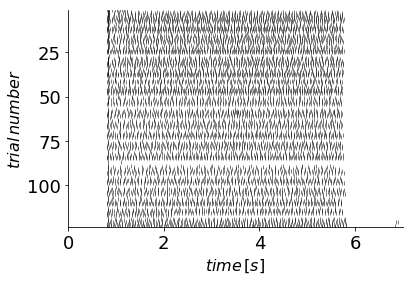

In [18]:
cell='7'
psth.raster(spiketime_information[cell]['spike_times'],npix_ch0_times[26:150]-start_time,
            timeDomain=True,pre=0.,post=7.,color='k',ms=4)

plot of neuropixels data with pipette timing, showing clock drift

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fad00ac6550>)

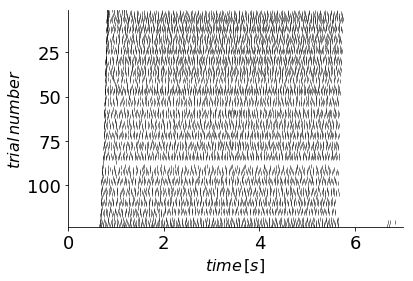

In [19]:
cell='7'
psth.raster(spiketime_information[cell]['spike_times'],patch_ch0_times[26:150]+offset,
            timeDomain=True,pre=0.,post=7.,color='k',ms=4)

uh oh, here we can see the clock drift between the patch event clock and the neuropixels clock

<br></br>
### show clock drift, and fix it

In [20]:
tem= (npix_ch0_times[:50]-start_time)-(patch_ch0_times[:50]+offset)
# tem= (npix_ch0_times-start_time)-(patch_ch0_times+offset)

Text(0.5, 0, 'event number')

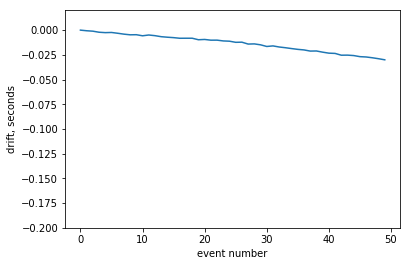

In [21]:
plt.plot(tem)
plt.ylim(-0.2,0.02)
plt.ylabel('drift, seconds')
plt.xlabel('event number')

make sure this is linear! if so, the below will work to make the pipette times on the neuropixels clock:

In [22]:
seconds_of_measured_drift = npix_ch0_times[50]-npix_ch0_times[0]
measured_drift = tem[-1]-tem[0]
seconds_of_drift_per_seconds = measured_drift/seconds_of_measured_drift
patch_ch0_times = patch_ch0_times + offset + ((patch_ch0_times+offset)*seconds_of_drift_per_seconds)
pip3_spike_times = pip3_spike_times + (pip3_spike_times*seconds_of_drift_per_seconds)

neuropixels spike times, triggered on patch event times:

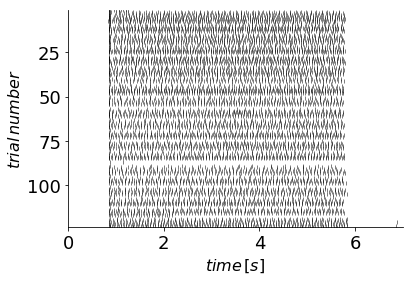

In [23]:
cell='7'
dump=psth.raster(spiketime_information[cell]['spike_times'],patch_ch0_times[26:150],
            timeDomain=True,pre=0.,post=7.,color='k',ms=4)

clock drift between the patch event clock and the neuropixels clock has been fixed!

In [24]:
pip3_spike_times

array([-13600.01752367, -13600.00342445, -13599.98468549, ...,
         4650.78660893,   4650.88475347,   4662.69833606])

check the timing of the extrated pipette spikes relative to the neuropixels data:

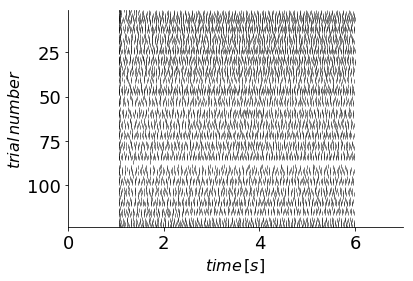

In [25]:
cell='7'
dump=psth.raster(pip3_spike_times,patch_ch0_times[26:150],
            timeDomain=True,pre=0.,post=7.,color='k',ms=4)

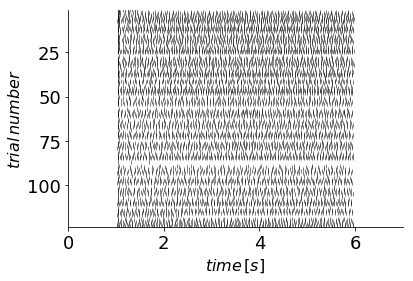

In [26]:
cell='7'
dump=psth.raster(pip3_spike_times,npix_ch0_times[26:150]-start_time,
            timeDomain=True,pre=0.,post=7.,color='k',ms=4)


<br></br>
<br></br>
<br></br><br></br>
## pipette spike triggered average of neuropixels raw data

first, the template, for sanity checking the waveform (EAP):

Text(0.5, 1.0, 'channels with signal > 50uv: 10')

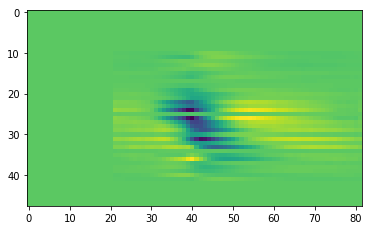

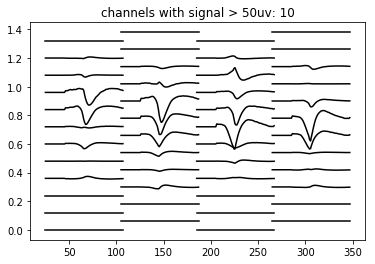

In [27]:
plt.imshow(spiketime_information[cell]['template'].T)
plt.figure()
good = []
for i,ch in enumerate(spiketime_information[cell]['template'].T):
    x_ = option234_positions[::-1][i][0]*5
    y_ = option234_positions[::-1][i][1]
    plt.plot(np.linspace(x_,x_+len(ch),len(ch)),ch+y_*.003,'k')
    if np.max(np.abs(ch)) > 0.05: good.extend([ch])
# plt.ylim(-.2,.1)
plt.title('channels with signal > 50uv: '+str(len(good)))
# plt.gcf().savefig(os.path.join('/Users/danieljdenman/Dropbox/allenTransfer/invitropanels','npix_template.png'),format='png',dpi=600)

#### now, get the waveform (EAP) from the neuropixels times:

specify where data is and load the data

In [28]:
number_of_spikes = 200
npix_selected_times = np.random.choice(spiketime_information[cell]['spike_times'],number_of_spikes,False)
pip3_selected_times = np.random.choice(pip3_spike_times,number_of_spikes,False)
data_path=glob.glob(os.path.dirname(path)+'/e*.dat')[0]

In [29]:
mm = np.memmap(data_path, dtype=np.int16, mode='r')

preprocessing: median subtract with a median of the first 30 channels

In [30]:
c = get_chunk(mm,npix_selected_times[0]-0.001,npix_selected_times[0]+0.002,100,sampling_rate=30000)
offset_c = np.mean(c,axis=1)
c_off = (c.transpose()-offset_c).transpose()
med = np.median(c_off[:30],axis=0)
data = c_off-med
for ti in npix_selected_times[1:]:
    c = get_chunk(mm,ti-0.001,ti+0.002,100,sampling_rate=30000)
    offset_c = np.mean(c,axis=1)
    c_off = (c.transpose()-offset_c).transpose()
    med = np.median(c_off[:20],axis=0)
    data += (c_off-med)


show the waveform (on the 100 recorded channels)

Text(0.5, 1.0, 'channels with signal > 50uv: 22')

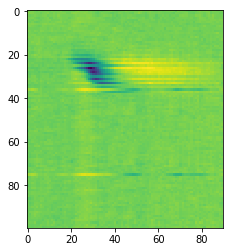

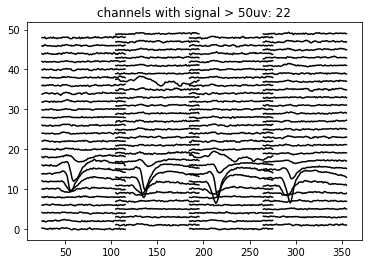

In [31]:
plt.imshow(data)
plt.figure()
good = []
for i,ch in enumerate(data):
    x_ = option234_positions[::-1][i][0]*5
    y_ = option234_positions[::-1][i][1]
    plt.plot(np.linspace(x_,x_+len(ch),len(ch)),ch+y_*.05,'k')
    if np.max(np.abs(ch)) > 0.5: good.extend([ch])
# plt.ylim(-.2,.1)
plt.title('channels with signal > 50uv: '+str(len(good)))
# plt.gcf().savefig(os.path.join('/Users/danieljdenman/Dropbox/allenTransfer/invitropanels','npix_template.png'),format='png',dpi=600)

#### and the waveform (EAP) from the patch spike times:

preprocessing: median subtract with a median of the first 30 channels

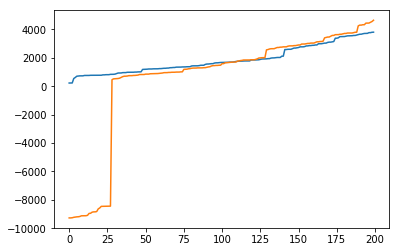

In [32]:
plt.plot(np.sort(npix_selected_times))
plt.plot(np.sort(pip3_selected_times))

In [42]:
pip3_selected_times = pip3_selected_times[pip3_selected_times > np.sort(npix_selected_times)[0]]-.2144

In [43]:
c = get_chunk(mm,pip3_selected_times[0]-0.001,pip3_selected_times[0]+0.002,100,sampling_rate=30000)
offset_c = np.mean(c,axis=1)
c_off = (c.transpose()-offset_c).transpose()
med = np.median(c_off[:30],axis=0)
data = c_off-med
for ti in pip3_selected_times[1:]:
    c = get_chunk(mm,ti-0.001,ti+0.002,100,sampling_rate=30000)
    try:
        offset_c = np.mean(c,axis=1)
        c_off = (c.transpose()-offset_c).transpose()
        med = np.median(c_off[:20],axis=0)
        data += (c_off-med)
    except: print('pipette spike time out of range: '+str(ti))

pipette spike time out of range: 4560.447414085121
pipette spike time out of range: 4503.949608305834
pipette spike time out of range: 4649.234283385359
pipette spike time out of range: 4333.474584997656
pipette spike time out of range: 4306.594740428142
pipette spike time out of range: 4333.624826636952
pipette spike time out of range: 4448.672544117427
pipette spike time out of range: 4445.59072561561
pipette spike time out of range: 4253.272437918195
pipette spike time out of range: 4305.899689106615
pipette spike time out of range: 4450.002130128133


show the waveform (on the 100 recorded channels)

Text(0.5, 1.0, 'channels with signal > 50uv: 7')

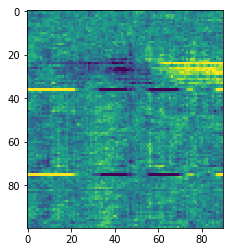

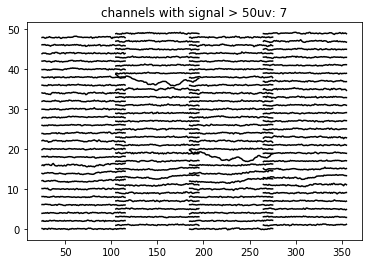

In [52]:
plt.imshow(data)
plt.clim(-.5,.5)
plt.figure()
good = []
for i,ch in enumerate(data):
    x_ = option234_positions[::-1][i][0]*5
    y_ = option234_positions[::-1][i][1]
    plt.plot(np.linspace(x_,x_+len(ch),len(ch)),ch+y_*.05,'k')
    if np.max(np.abs(ch)) > .5: good.extend([ch])
# plt.ylim(-.2,.1)
plt.title('channels with signal > 50uv: '+str(len(good)))
# plt.gcf().savefig(os.path.join('/Users/danieljdenman/Dropbox/allenTransfer/invitropanels','npix_template.png'),format='png',dpi=600)